# 1.1 Поліноми Лагерра 
Поліномами Лаґерра називаються розв'язки диференційного рівняння $$xy^{\prime\prime}+(1-x)*y^\prime+ny=0$$

Полiноми Лагера визначаються формулою: $$L_n(x)= \frac{e^x}{n!}\frac{d^n}{dx^n}(e^{-x}*x^n)$$

# 1.2 Функцiї Лагерра
Функцiї Лаґерра задають формулою: $$l_n(t) := \sqrt{σ}L_n(σt)e^{\frac{-β}{2}t}$$
де
- Ln – полiноми Лаґерра,
- 0 ≤ β ≤ σ – параметри, дiйснi числа

Для обчислень функцiй Лаґерра використовують рекурентну формулу:

- $l_n(t)=\frac{2n-1-σt}{n}l_{n-1}(t)-\frac{n-1}{n}l_{n-2}(t),$ n≥2
- $l_0(t)= \sqrt{σ} e^{\frac{-β}{2}t}$
- $l_1(t)=\sqrt{σ}(1-σt)e^{\frac{-β}{2}t}$


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import unittest
import scipy.special as sp
import ipywidgets as widgets
from IPython.display import display, clear_output

В даній реалізації програми ви використовуємо об'єктно-орієнтований підхід. У нас є основий клас Laguerre в якому є поля beta, sigma, n, eps, t_max, t_points а також методи laguerre для обчислення полінома, метод experiment та методи для табуляції та перетворення.

In [3]:
class Laguerre:
    def __init__(self, beta=2, sigma=4, n=20, eps=0.001, t_max=100, t_points=1000):
        self._beta = beta
        self._sigma = sigma
        self._n = n
        self._eps = eps
        self._t_max = t_max
        self._t_points = t_points



    @property
    def beta(self):
        return self._beta
    
    @beta.setter
    def beta(self, value):
        if not isinstance(value, (int, float)):
            raise ValueError("Beta must be a number")
        if value <= 0:
            raise ValueError("Beta must be a positive number")
        self._beta = value

    @property
    def sigma(self):
        return self._sigma
    
    @sigma.setter
    def sigma(self, value):
        if not isinstance(value, (int, float)):
            raise ValueError("Sigma must be a number")
        elif value <= 0:
            raise ValueError("Sigma must be a positive number")
        else:
            self._sigma = value

    @property
    def n(self):
        return self._n
    
    @n.setter
    def n(self, value):
        if not isinstance(value, int):
            raise ValueError("n must be an integer")
        if value < 0:
            raise ValueError("n must be a non-negative integer")
        else:
            self._n = value

    @property
    def eps(self):
        return self._eps
    
    @eps.setter
    def eps(self, value):
        if not isinstance(value, (int, float)):
            raise ValueError("Epsilon must be a number")
        if value <= 0:
            raise ValueError("Epsilon must be a positive number")
        else:
            self._eps = value

    @property
    def t_max(self):
        return self._t_max
    
    @t_max.setter
    def t_max(self, value):
        if not isinstance(value, (int, float)):
            raise ValueError("t_max must be a number")
        elif value <= 0:
            raise ValueError("t_max must be a positive number")
        else:
            self._t_max = value

    @property
    def t_points(self):
        return self._t_points
    
    @t_points.setter
    def t_points(self, value):
        if not isinstance(value, int):
            raise ValueError("t_points must be an integer")
        if value <= 0:
            raise ValueError("t_points must be a positive integer")
        else:
            self._t_points = value

    def laguerre(self, t, n):
        l0 = np.sqrt(self.sigma) * (np.exp(-self.beta * t / 2))
        l1 = np.sqrt(self.sigma) * (1 - self.sigma * t) * (np.exp(-self.beta * t / 2))
        if n == 0:
            return l0
        elif n == 1:
            return l1
        else:
            lnext = (2 * 2 - 1 - t * self.sigma) / 2 * l1 - (2 - 1) / 2 * l0
            for j in range(3, n + 1):
                l0 = l1
                l1 = lnext
                lnext = (2 * j - 1 - t * self.sigma) / j * l1 - (j - 1) / j * l0 
            return lnext

    def experiment(self):
        suitable_t = None
        T = np.linspace(0, self.t_max, self.t_points)
        N = range(0, self.n + 1)
        for t in T:
            is_t_suitable = all(abs(self.laguerre(t, n)) < self.eps for n in N)
            if is_t_suitable and suitable_t is None:
                suitable_t = t
                break
        return suitable_t, N

    def transform_laguerre(self, f, n):
        def func(t):
            alpha = self.sigma-self.beta 
            
            return f(t)*self.laguerre(t,n) * np.exp(-alpha*t)
        t = self.experiment()[0]

        return quad(func,0,t)[0]


    def tabulate_transformation(self, f, N):
        result = []
        for n in range(N+1):
            result.append(self.transform_laguerre(f, n))
        return result


    def tabulate_laguerre(self, T, num_points=100):
        t_values = np.linspace(0, T, num_points)
        laguerre_values = [self.laguerre(t, self.n) for t in t_values]
        return t_values, laguerre_values
    

Наслідую від основного класу новий клас LaguerreInverse та додаю методи для оберненного перетворення та табуляції

In [4]:
class LaguerreInverse(Laguerre):
    def __init__(self, beta=2, sigma=4, n=20, eps=0.001, t_max=100, t_points=1000):
        super().__init__(beta, sigma, n, eps, t_max, t_points)

    def inverse_laguerre(self, h, t):
        result = 0
        for i, coeff in enumerate(h):
            result += coeff * super().laguerre(t, i)
        return result

    def tabulate_inverse(self, func,transformed_values,t1=0,t2=2*np.pi):
        T = np.linspace(t1,t2,1000)
        result =[]
        correct_values = []
        for t in T:
            result.append(self.inverse_laguerre(transformed_values,t))
            correct_values.append(func(t))
        return result,correct_values
    

Також реалізовую клас LaguerrePlots для роботи з графіками та наслідую від основого

In [5]:
class LaguerrePlots(Laguerre):
    def __init__(self, beta=2, sigma=4, n=20, eps=0.001, t_max=100, t_points=1000):
        super().__init__(beta, sigma, n, eps, t_max, t_points)


    def make_plots(self, T, N):
        fig, ax = plt.subplots(figsize=(10, 10))

        for n in range(N + 1):
            t_values = np.linspace(0, T, self.t_points)
            laguerre_values = [super().laguerre(t, n) for t in t_values]
            ax.plot(t_values, laguerre_values, label=f"n={n}")

        ax.set_xlabel("t")
        ax.set_ylabel("l(t)")
        ax.set_title("Laguerre Functions")
        plt.grid()
        ax.legend()
        plt.show()
            

In [6]:
# task 1
laguerre = Laguerre()

laguerre.laguerre(1,5)



-0.6376576980305

In [7]:
# task 2
laguerre = Laguerre()
t_values,laguerre_values = laguerre.tabulate_laguerre(10)
df = pd.DataFrame(laguerre_values,t_values)
df

,0
0.00000,2.000000
0.10101,0.169321
0.20202,0.345063
0.30303,-0.660196
0.40404,-0.220724
...,...
9.59596,3500.547079
9.69697,3525.306973
9.79798,3343.954381
9.89899,2926.972564


In [9]:
# task 3

t,N = laguerre.experiment()


df = pd.DataFrame(laguerre.laguerre(t=t, n=n) for n in N)
df

,0
0,9.066138e-35
1,-2.858701e-32
2,4.478343e-30
3,-4.647081e-28
4,3.593209e-26
5,-2.208132e-24
6,1.123332e-22
7,-4.865604e-21
8,1.831625e-19
9,-6.087176e-18


In [10]:
def f(t):
    if t >= 0 and t <= 2*np.pi:
        return np.sin(t-np.pi/2) + 1
    else:
        return 0

n_slider = widgets.IntSlider(min=0,max=20,  continuous_update=False)


output_exp = widgets.Output()

def update_experiment(change):
    with output_exp:
        laguerre = Laguerre()
        clear_output(wait=True)
        results = laguerre.tabulate_transformation(f, n_slider.value)
        df = pd.DataFrame(results)
        display(df)
        
n_slider.observe(update_experiment, 'value')
display(widgets.VBox([n_slider]))
display(output_exp)

Output()

# 1.3 Перетворення Лаґерра (ПЛ)
Пiд ПЛ будемо розумiти вiдображення L :$ L^2_a(R_+)$ → *$l^2$*, яке довiльнiй функцiї f ∈ $L^2_a$ ставить у вiдповiднiсть послiдовнiсть f := (f0, f1, ..., fk, ...)⊤∈ $l^2$
за формулою $$f_k = \int_{R_+}^{} f(t)l_k(t) e^{-αt}\, dt$$  
$$a=σ-β$$



## Нам дана функція:$$f(t)= sin(t-\frac{\pi}{2})+1, t∈[0,2\pi]$$ 
## $$f(t)=0$$ в інших випадках

In [11]:
# task 5
def f(t):
    if t >= 0 and t <= 2*np.pi:
        return np.sin(t-np.pi/2) + 1
    else:
        return 0
    

result = laguerre.tabulate_transformation(f, 20)
df = pd.DataFrame(result)
df

,0
0,0.066667
1,-0.182222
2,0.178074
3,-0.074290
4,0.007264
5,0.007588
6,-0.003097
7,-0.000615
8,0.000800
9,-0.000026


# 1.4 Обернене перетворення Лагера 
Обернене перетворення Лагера ставить у вiдповiднiсть вектору значень h := (h0, h1, . . . , hk, . . .)
функцiю h(t) $$h(t)=\sum_{k=0}^\infty h_kl_k(t) $$

In [12]:
# task 6

h_values = [1, 2, 3] 
t_value = 0.5

laguerreInv = LaguerreInverse()

result = laguerreInv.inverse_laguerre(h_values, t_value)

print(result)

-4.852245277701067


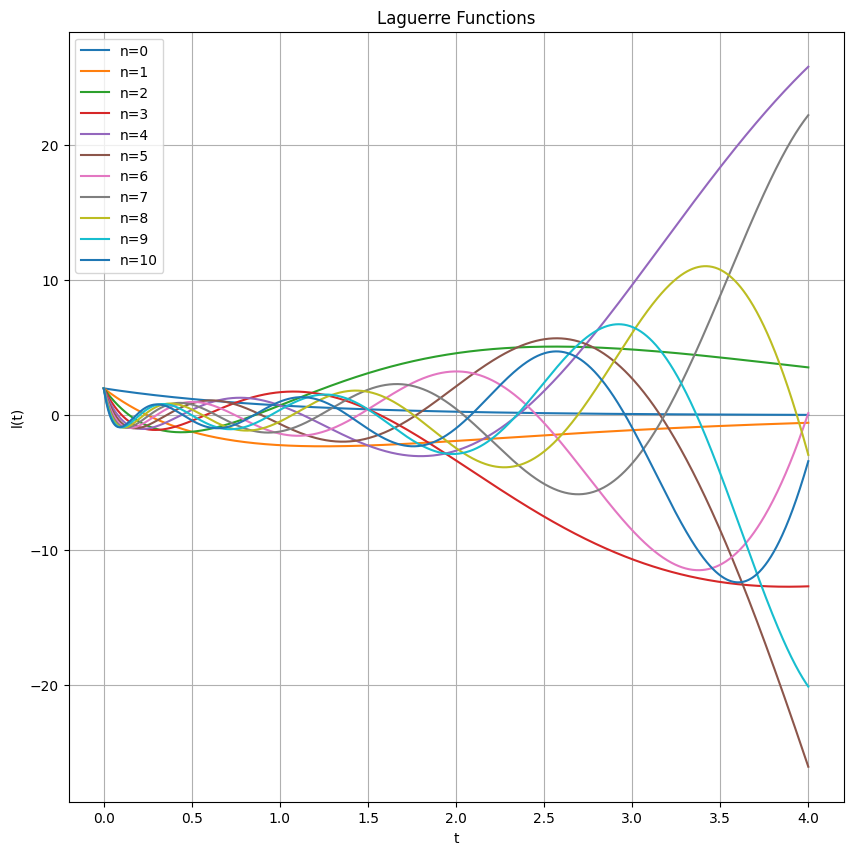

In [13]:
# task 7

plot = LaguerrePlots()
plot.make_plots(4,10)


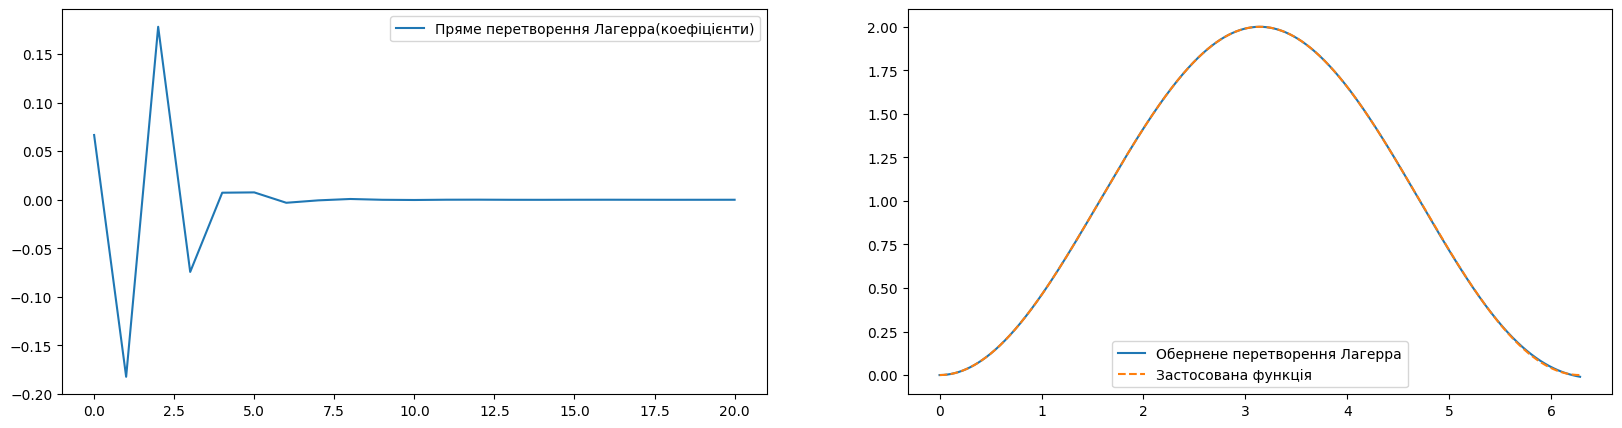

In [14]:
transformed = laguerreInv.tabulate_transformation(f, 20)
inverse, correct = laguerreInv.tabulate_inverse(f, transformed)

fig = plt.figure(figsize=(20,5))
ax = fig.subplots(1,2)
ax[0].plot(transformed, label="Пряме перетворення Лагерра(коефіцієнти)")
ax[0].legend()
ax[1].plot(np.linspace(0,2*np.pi,1000),inverse, label='Обернене перетворення Лагерра')
ax[1].plot(np.linspace(0,2*np.pi,1000),correct, label='Застосована функція', linestyle="--")
ax[1].legend()

В попередній комірці ми отримали два графіки: на першому відображені
коефіцієнти прямого перетворення Лаґерра, а на другому обернене
перетворення, а також значення нашої функції. 
Як бачимо, ці графіки
співпадають, що дає нам змогу удостовіритись у правильності побудови
обернено перетворення Лаґерра.

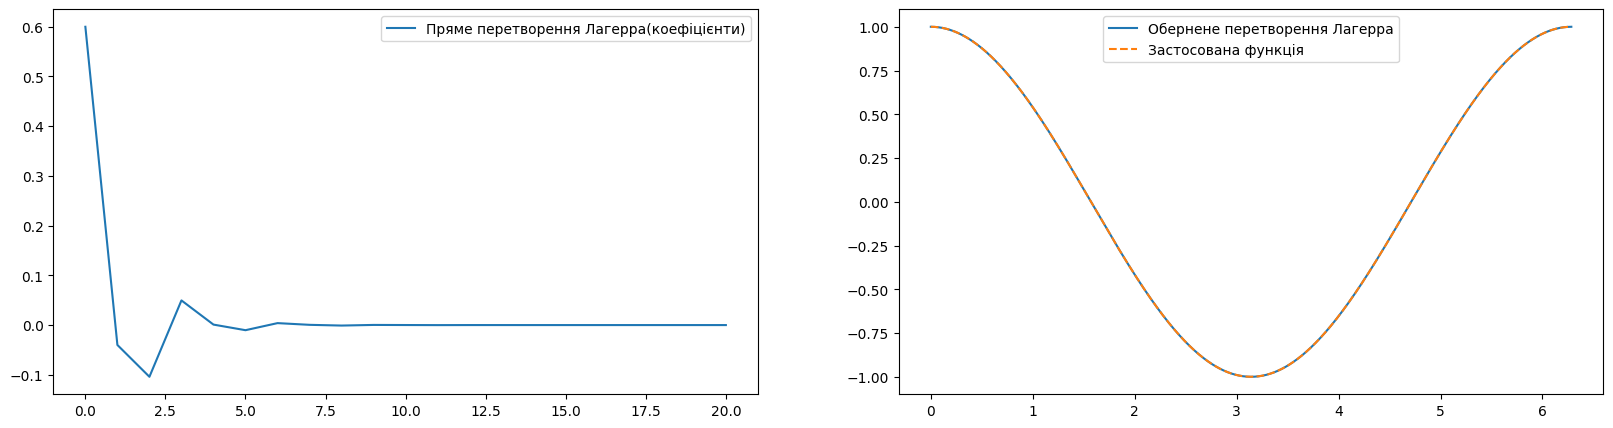

In [15]:
def example(x):
    return np.cos(x)



result = laguerreInv.tabulate_transformation(example, 20)

reversed_transform, correct_values = laguerreInv.tabulate_inverse(example,result)

fig = plt.figure(figsize=(20,5))
ax = fig.subplots(1,2)
ax[0].plot(result, label="Пряме перетворення Лагерра(коефіцієнти)")
ax[0].legend()
ax[1].plot(np.linspace(0,2*np.pi,1000),reversed_transform, label='Обернене перетворення Лагерра')
ax[1].plot(np.linspace(0,2*np.pi,1000),reversed_transform, label='Застосована функція', linestyle="--")
ax[1].legend()

В наступній комірці реалізовані тести за допомогою бібліотеки unittest

In [16]:
class TestLaguerre(unittest.TestCase):
    def test_laguerre_setter(self):
        laguerre = Laguerre()
        laguerre.beta = 1
        self.assertEqual(laguerre.beta, 1)
        laguerre.sigma = 1
        self.assertEqual(laguerre.sigma, 1)
        laguerre.n = 1
        self.assertEqual(laguerre.n, 1)
        laguerre.eps = 1
        self.assertEqual(laguerre.eps, 1)
        laguerre.t_max = 1
        self.assertEqual(laguerre.t_max, 1)
        laguerre.t_points = 1
        self.assertEqual(laguerre.t_points, 1)
    
    def test_laguerre(self):
        laguerre = Laguerre()
        self.assertEqual(round(laguerre.laguerre(1, 5),5), -0.63766)
        self.assertEqual(round(laguerre.laguerre(1, 2),5), 0.73576)
        self.assertEqual(round(laguerre.laguerre(1, 1),5), -2.20728)


    def test_experiment(self):
        laguerre = Laguerre()
        t,N = laguerre.experiment()
        self.assertEqual(t, 79.07907907907908)
        self.assertEqual(N, range(0, 21))

    def test_transform_laguerre(self):
        laguerre = Laguerre()
        result = laguerre.tabulate_transformation(f, 20)
        self.assertEqual(result[0],0.06666666623638996)
        self.assertEqual(result[1],-0.18222221012567946)

    def test_tabulate_laguerre(self):
        laguerre = Laguerre()
        t_values,laguerre_values = laguerre.tabulate_laguerre(10)
        self.assertEqual(laguerre_values[0], 2.0)
        self.assertEqual(laguerre_values[1], 0.16932141072843784)
        
    

In [17]:
class TestLaguerreInverse(unittest.TestCase):
    def test_inverse_laguerre(self):
        laguerre = LaguerreInverse()
        h_values = [1, 2, 3] 
        t_value = 0.5
        self.assertAlmostEqual(round(laguerre.inverse_laguerre(h_values, t_value),5), -4.85225)

In [18]:
unittest.main(argv=[''], exit=False)

......
----------------------------------------------------------------------
Ran 6 tests in 1.835s

OK


У результаті лабораторної роботи ми вивчили що таке поліноми Лаґерра, написали класи для їх знаходження та методи для прямого та клас для обернего перетворення та як застосовувати до них табуляцію.
    Навчились будувати таблиці за допомогою pandas та створювати графіки за допомогою matplotlib, а також створювати тести за допомогою бібліотеки unittest.
Навчилися працювати у форматі ноутбуків, та як переводити 
їх у формат PDF за допомогою latex.